# CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 


In [1]:
# Importing relevant modules
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [4]:
# Have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [6]:
# Assigning new train and test datasets. 80/20 split.
print(len(raw_training_data) * 0.8)
new_train = raw_training_data[:6253]
new_test = raw_training_data[6253:]

# Checking data lengths
print(len(new_train))
print(len(new_test))

6252.8
6253
1563


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
# Initialising new training data
training_data = [preProcess(example) for example in new_train]

In [9]:
# Check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# Let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# An example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      B-Plot
is          I-Plot
the         I-Plot
main        I-Plot
character   I-Plot
in          I-Plot
batman      I-Plot
begins      I-Plot


In [15]:
# Another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# Load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# Prepare new test data:
test_data = [preProcess(example) for example in new_test]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1563 instances
31282 words


In [17]:
# Generation of predictions
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1229
         B-Award       0.77      0.62      0.69        74
B-Character_Name       0.65      0.13      0.22       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1219
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.89      0.84      0.87      1729
         I-Award       0.83      0.80      0.82       202
I-Character_Name       0.61      0.12      0.20       165
      I-Director       0.86      0.66      0.74       456
         I-Ge

In [19]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

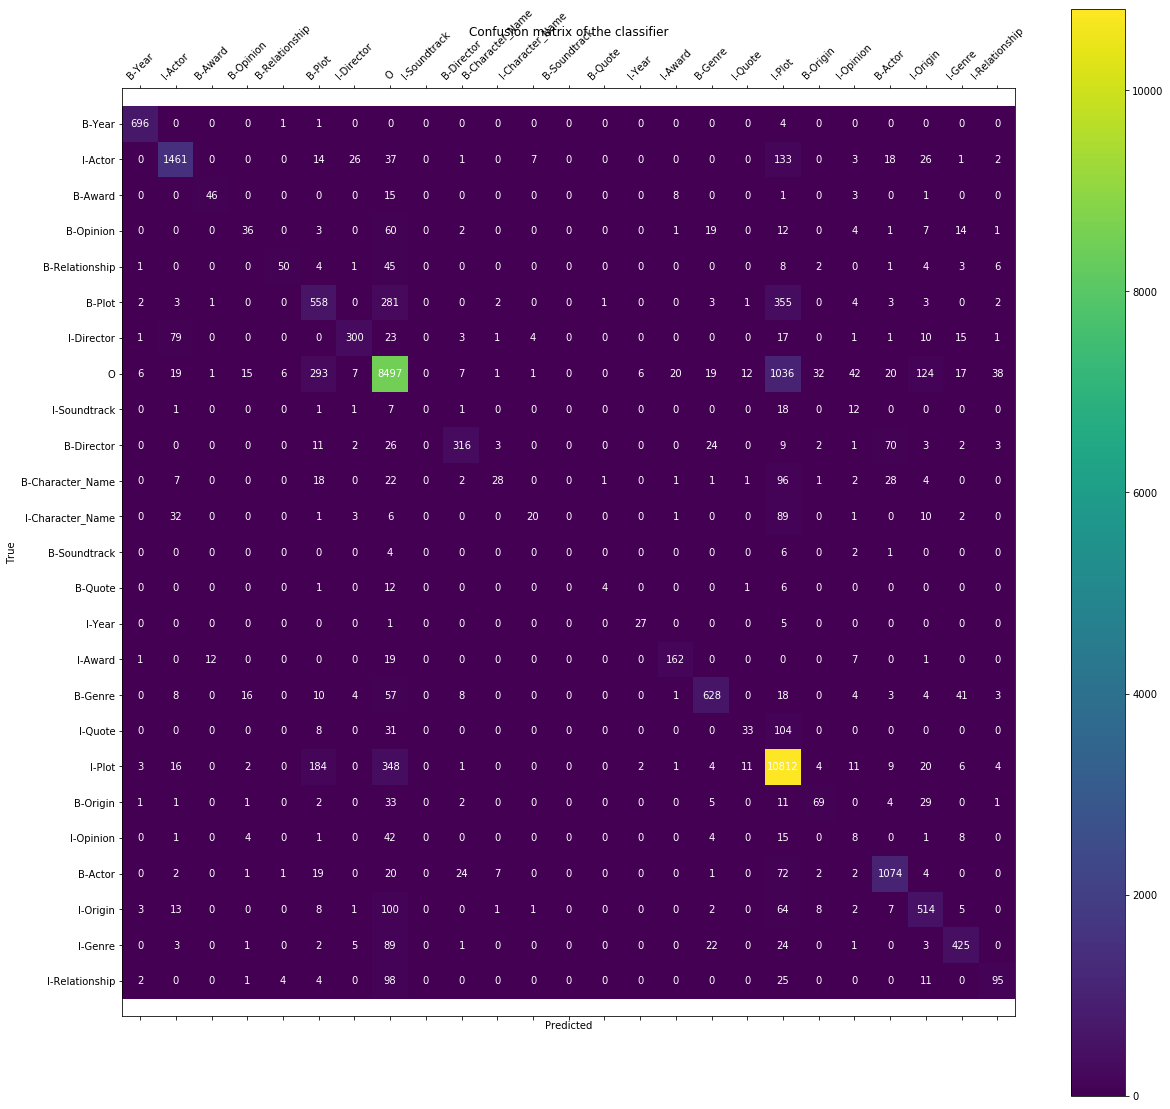

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [22]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [23]:
print_transition_weights(ct._tagger.info().transitions.items())

8.472356 B-Actor  -> I-Actor
8.067710 B-Plot   -> I-Plot
7.806803 B-Director -> I-Director
7.577788 B-Origin -> I-Origin
7.536016 I-Plot   -> I-Plot
7.337922 I-Quote  -> I-Quote
7.215566 B-Character_Name -> I-Character_Name
7.120720 I-Origin -> I-Origin
6.978525 B-Relationship -> I-Relationship
6.796261 I-Relationship -> I-Relationship
6.793224 B-Quote  -> I-Quote
6.652587 I-Opinion -> I-Opinion
6.629131 I-Soundtrack -> I-Soundtrack
6.519724 B-Genre  -> I-Genre
6.271979 I-Award  -> I-Award
6.251937 B-Award  -> I-Award
6.190079 B-Soundtrack -> I-Soundtrack
6.188616 B-Opinion -> I-Opinion
6.137007 I-Genre  -> I-Genre
5.974189 I-Actor  -> I-Actor
5.966186 I-Character_Name -> I-Character_Name
5.025413 I-Director -> I-Director
4.625996 I-Year   -> I-Year
3.829132 B-Year   -> I-Year
3.708732 B-Character_Name -> B-Plot
3.511382 O        -> O
3.314895 I-Character_Name -> B-Plot
3.239670 O        -> B-Plot
3.000417 B-Opinion -> B-Genre
2.991544 B-Plot   -> B-Character_Name
2.911353 O        -> 

In [24]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [25]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.080979 B-Year   HAS_NUM
4.171149 I-Year   WORD_s
4.102801 B-Genre  WORD_animated
2.902563 B-Quote  WORD_i
2.898781 B-Plot   WORD_a
2.877423 B-Genre  WORD_action
2.876413 B-Genre  WORD_thriller
2.830782 I-Genre  WORD_animated
2.602372 B-Relationship SUF_uel
2.565218 B-Award  WORD_oscar
2.549231 B-Opinion WORD_blockbuster
2.447598 B-Award  SUF_car
2.433486 I-Genre  WORD_fiction
2.401157 B-Actor  WORD_cher
2.373523 B-Genre  WORD_slasher
2.372945 B-Genre  WORD_animation
2.357330 B-Genre  WORD_comedy
2.326671 B-Genre  WORD_horror
2.301916 B-Director WORD_disney
2.276007 B-Origin WORD_adapted
2.270848 I-Genre  WORD_thriller
2.261455 B-Plot   WORD_an
2.249060 B-Relationship WORD_remake
2.245117 B-Actor  WORD_fred
2.209513 I-Actor  WORD_cage
2.202433 B-Genre  WORD_war
2.191111 I-Genre  WORD_white
2.189042 B-Relationship WORD_sequel
2.184318 B-Opinion WORD_masterpiece
2.175177 B-Character_Name WORD_dorothy
2.172480 B-Director SUF_xar
2.172480 B-Director WORD_pixar
2.141437 B-Character_Name WO

# 1. Split the training data into 80% training, 20% development set (5 marks)


In [26]:
#New training and development data sets are created in cell 7 and implemented in the model above

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [27]:
# Finding classes with lowest precision
import pandas as pd
report = classification_report(y_test, preds, output_dict=True)
# Transformation to dataframe to find lowest precisions
df1 = pd.DataFrame(report).transpose()
print('THE CLASSES WITH THE LOWEST PRECISION: ')
display(df1.nsmallest(5,'precision'))
print('\n')

# B-Soundtrack FPs
BS_count = 0
print('False positive instances for B-Soundtrack Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'B-Soundtrack':
            if sent_true[i] != 'B-Soundtrack':
                print(sent)
                BS_count += 1
                print('False Positive at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false positives for B-Soundtrack: ' + str(BS_count))
print('\n')

# I-Soundtrack FPs
IS_count = 0
print('False positive instances for I-Soundtrack Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'I-Soundtrack':
            if sent_true[i] != 'I-Soundtrack':
                print(sent)
                IS_count += 1
                print('False Positive at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false positives for I-Soundtrack: ' + str(IS_count))
print('\n')

# I-Opinion FPs
IO_count = 0
print('False positive instances for I-Opinion Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'I-Opinion':
            if sent_true[i] != 'I-Opinion':
                print(sent)
                IO_count += 1
                print('False Positive at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false positives for I-Opinion: ' + str(IO_count))
print('\n')

# B-Opinion FPs
BO_count = 0
print('False positive instances for B-Opinion Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'B-Opinion':
            if sent_true[i] != 'B-Opinion':
                print(sent)
                BO_count += 1
                print('False Positive at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false positives for B-Opinion: ' + str(BO_count))
print('\n')

# B-Plot FPs
BP_count = 0
print('False positive instances for B-Plot Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'B-Plot':
            if sent_true[i] != 'B-Plot':
                print(sent)
                BP_count += 1
                print('False Positive at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false positives for B-Plot: ' + str(BP_count))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


THE CLASSES WITH THE LOWEST PRECISION: 


,precision,recall,f1-score,support
B-Soundtrack,0.000000,0.000000,0.000000,13.0
I-Soundtrack,0.000000,0.000000,0.000000,41.0
I-Opinion,0.072727,0.095238,0.082474,84.0
B-Opinion,0.467532,0.225000,0.303797,160.0
B-Plot,0.488189,0.457752,0.472481,1219.0




False positive instances for B-Soundtrack Tag
Total number of false positives for B-Soundtrack: 0


False positive instances for I-Soundtrack Tag
Total number of false positives for I-Soundtrack: 0


False positive instances for I-Opinion Tag
[('play', 'B-Quote'), ('it', 'I-Quote'), ('again', 'I-Quote'), ('sam', 'I-Quote'), ('is', 'O'), ('one', 'O'), ('of', 'O'), ('the', 'O'), ('memorable', 'O'), ('quotes', 'O'), ('from', 'O'), ('this', 'O'), ('classic', 'B-Opinion'), ('humphrey', 'B-Actor'), ('bogart', 'I-Actor'), ('romance', 'B-Genre')]
False Positive at index: 13
Word: humphrey
Ground Truth: B-Actor
Prediction: I-Opinion


[('play', 'B-Quote'), ('it', 'I-Quote'), ('again', 'I-Quote'), ('sam', 'I-Quote'), ('is', 'O'), ('one', 'O'), ('of', 'O'), ('the', 'O'), ('memorable', 'O'), ('quotes', 'O'), ('from', 'O'), ('this', 'O'), ('classic', 'B-Opinion'), ('humphrey', 'B-Actor'), ('bogart', 'I-Actor'), ('romance', 'B-Genre')]
False Positive at index: 14
Word: bogart
Ground Truth: I-Actor

# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [28]:
# Finding classes with lowest recall
print('THE CLASSES WITH THE LOWEST PRECISION: ')
display(df1.nsmallest(5,'recall'))

# B-Soundtrack FNs
BS_count1 = 0
print('False negative instances for B-Soundtrack Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_true[i] == 'B-Soundtrack':
            if sent_preds[i] != 'B-Soundtrack':
                print(sent)
                BS_count1 += 1
                print('False Negative at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false negatives for B-Soundtrack: ' + str(BS_count1))
print('\n')

# I-Soundtrack FNs
IS_count1 = 0
print('False negative instances for I-Soundtrack Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_true[i] == 'I-Soundtrack':
            if sent_preds[i] != 'I-Soundtrack':
                print(sent)
                IS_count1 += 1
                print('False Negative at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false negatives for I-Soundtrack: ' + str(IS_count1))
print('\n')

# I-Opinion FNs
IO_count1 = 0
print('False negative instances for I-Opinion Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_true[i] == 'I-Opinion':
            if sent_preds[i] != 'I-Opinion':
                print(sent)
                IO_count1 += 1
                print('False Negative at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false negatives for I-Opinion: ' + str(IO_count1))
print('\n')

# I-Character_Name FNs
IC_count = 0
print('False negative instances for I-Character_Name Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'I-Character_Name':
            if sent_true[i] != 'I-Character_Name':
                print(sent)
                IC_count += 1
                print('False Negative at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false negatives for I-Character_Name: ' + str(IC_count))
print('\n')

# B-Character_Name FNs
BC_count = 0
print('False negative instances for B-Character_Name Tag')
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for i in range(len(sent_preds)):
        if sent_preds[i] == 'B-Character_Name':
            if sent_true[i] != 'B-Character_Name':
                print(sent)
                BC_count += 1
                print('False Negative at index: ' + str(i))
                print('Word: ' + str(sent[i][0]))
                print('Ground Truth: ' + str(sent_true[i]))
                print('Prediction: ' + str(sent_preds[i]))
                print('\n')
print('Total number of false negatives for B-Character_Name: ' + str(BC_count))

THE CLASSES WITH THE LOWEST PRECISION: 


,precision,recall,f1-score,support
B-Soundtrack,0.000000,0.000000,0.000000,13.0
I-Soundtrack,0.000000,0.000000,0.000000,41.0
I-Opinion,0.072727,0.095238,0.082474,84.0
I-Character_Name,0.606061,0.121212,0.202020,165.0
B-Character_Name,0.651163,0.132075,0.219608,212.0


False negative instances for B-Soundtrack Tag
[('this', 'O'), ('1990', 'B-Year'), ('s', 'I-Year'), ('animated', 'B-Genre'), ('feature', 'I-Genre'), ('taught', 'O'), ('us', 'O'), ('the', 'O'), ('song', 'O'), ('hakuna', 'B-Soundtrack'), ('matata', 'I-Soundtrack'), ('which', 'O'), ('championed', 'O'), ('a', 'O'), ('down', 'O'), ('to', 'O'), ('earth', 'O'), ('problem', 'O'), ('free', 'O'), ('philosophy', 'O')]
False Negative at index: 9
Word: hakuna
Ground Truth: B-Soundtrack
Prediction: B-Actor


[('this', 'O'), ('black', 'B-Genre'), ('and', 'I-Genre'), ('white', 'I-Genre'), ('comedy', 'I-Genre'), ('directed', 'O'), ('by', 'O'), ('mel', 'B-Director'), ('brooks', 'I-Director'), ('stars', 'O'), ('gene', 'B-Actor'), ('wilder', 'I-Actor'), ('and', 'O'), ('peter', 'B-Actor'), ('boyle', 'I-Actor'), ('and', 'O'), ('features', 'O'), ('the', 'O'), ('classic', 'B-Genre'), ('song', 'O'), ('puttin', 'B-Soundtrack'), ('on', 'I-Soundtrack'), ('the', 'I-Soundtrack'), ('ritz', 'I-Soundtrack')]
False Nega

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [29]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [30]:
# Function to add POS tags to words with separater '@'
def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    preprocessed_example = [('@'.join([s[0], pos[1]]), s[1]) for s,pos in zip(example, pos)]
    return preprocessed_example

# Addition of POS tags
training_data = [preProcess(example) for example in new_train]

# Testing the function
print(training_data[0])

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [31]:
# Definition of get_features function to include POS tags as a feature
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    # POS tag
    feature_list.append('POS_' + POS_tag)

    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name', 'B-Actor'),0))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'POS_Name', 'WORD_Michael']


In [32]:
# Initialising tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

# Training the model
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [33]:
ct.set_model_file(TAGGER_PATH)  # load model from file

# preparing the test data:
test_data = [preProcess(example) for example in new_test]

In [34]:
# Testing tagger
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([(s[0]) for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [35]:
# Classification report with POS tags
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1229
         B-Award       0.78      0.61      0.68        74
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.52      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.47      1219
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.88      0.88      0.88      1729
         I-Award       0.80      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76       456
         I-Ge

In [36]:
# Comparison of class metrics from before and post POS tagging

# Creation of new classification_report
report_POS = classification_report(y_test, preds, output_dict=True)
df2 = pd.DataFrame(report_POS).transpose()

# Subtraction of the 2 dataframes. POS - Original. To see classification movements.
comparison_df = df2 - df1
display(comparison_df)

,precision,recall,f1-score,support
B-Actor,-0.006618,0.012205,0.002608,0.000000
B-Award,0.009195,-0.013514,-0.004749,0.000000
B-Character_Name,-0.088663,-0.004717,-0.011916,0.000000
B-Director,-0.005677,0.019068,0.009635,0.000000
B-Genre,0.001366,0.001242,0.001301,0.000000
B-Opinion,0.051455,0.031250,0.039299,0.000000
B-Origin,-0.042742,-0.018868,-0.028193,0.000000
B-Plot,0.004731,-0.000820,0.001763,0.000000
B-Quote,-0.095238,0.000000,-0.008602,0.000000
B-Relationship,0.033548,0.104000,0.095241,0.000000


# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [37]:
# Prefix Feature Addition
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])
        
    
    # POS tag
    feature_list.append('POS_' + POS_tag)

    feature_list.append("WORD_" + token)
    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name', 'B-Actor'),0))

# Initialising tagger model
ct1 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
training_data = [preProcess(example) for example in new_train]

# Training model
print("training tagger...")
ct1.train(training_data, TAGGER_PATH)
print("done")

# Testing model
print("testing tagger...")
preds = []
y_test = []
testing_data = [preProcess(example) for example in new_test]
for sent in testing_data:
    sent_preds = [x[1] for x in ct1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'POS_Name', 'WORD_Michael']
training tagger...
done
testing tagger...
done


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.86      1229
         B-Award       0.76      0.59      0.67        74
B-Character_Name       0.57      0.16      0.24       212
      B-Director       0.84      0.69      0.76       472
         B-Genre       0.87      0.79      0.83       805
       B-Opinion       0.55      0.31      0.40       160
        B-Origin       0.55      0.43      0.48       159
          B-Plot       0.51      0.47      0.49      1219
         B-Quote       0.44      0.17      0.24        24
  B-Relationship       0.89      0.53      0.66       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.87      0.88      0.87      1729
         I-Award       0.76      0.82      0.79       202
I-Character_Name       0.48      0.16      0.24       165
      I-Director       0.85      0.68      0.76       456
         I-Ge

In [38]:
# Window feature to consider the preceding word

# Altering of the preProcess function to include preceding word
def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    prev_word = []
    for i in range(len(example)):
        if i == 0:
            prev_word.append('<S>')
        else:
            prev_word.append(example[i - 1][0])
    preprocessed_example = [list(('@'.join([s[0], pos[1]]), s[1])) for s,pos in zip(example, pos)]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '~' + prev_word[i]
    preprocessed_example = [tuple(l) for l in preprocessed_example]
    return preprocessed_example

# Addition of POS tags, prefixes and previous word
training_data = [preProcess(example) for example in new_train]

# Prefix Feature

def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1].split('~')[0]
    window = token.split('@')[1].split('~')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])
        
    # Window
    feature_list.append('prevwind_' + window)
        
    # POS tag
    feature_list.append('POS_' + POS_tag)

    feature_list.append("WORD_" + token)
    
    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name~When', 'B-Actor'),0))


# Initialising tagger model
ct2 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
training_data = [preProcess(example) for example in new_train]

# Training model
print("training tagger...")
ct2.train(training_data, TAGGER_PATH)
print("done")

# Testing model
print("testing tagger...")
preds = []
y_test = []
testing_data = [preProcess(example) for example in new_test]
for sent in testing_data:
    sent_preds = [x[1] for x in ct2.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'prevwind_When', 'POS_Name', 'WORD_Michael']
training tagger...
done
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.90      0.92      0.91      1229
         B-Award       0.78      0.64      0.70        74
B-Character_Name       0.78      0.33      0.47       212
      B-Director       0.89      0.75      0.81       472
         B-Genre       0.87      0.81      0.84       805
       B-Opinion       0.55      0.29      0.38       160
        B-Origin       0.59      0.48      0.53       159
          B-Plot       0.51      0.47      0.49      1219
         B-Quote       0.58      0.29      0.39        24
  B-Relationship       0.79      0.50      0.61       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.91      0.94      0.92      1729
         I-Award   

In [39]:
# Window to consider the next word

# Altering of preProcess function to include succeeding word
def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    prev_word = []
    for i in range(len(example)):
        if i == 0:
            prev_word.append('<S>')
        else:
            prev_word.append(example[i - 1][0])
    next_word = []
    for i in range(len(example)):
        if i == len(example) - 1:
            next_word.append('<E>')
        else:
            next_word.append(example[i + 1][0])
    preprocessed_example = [list(('@'.join([s[0], pos[1]]), s[1])) for s,pos in zip(example, pos)]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '~' + prev_word[i]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + next_word[i]
    preprocessed_example = [tuple(l) for l in preprocessed_example]
    return preprocessed_example

# Addition of POS tags, prefixes, previous & next words
training_data = [preProcess(example) for example in new_train]

def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1].split('~')[0]
    prev_window = token.split('@')[1].split('~')[1].split('±')[0]
    next_window = token.split('@')[1].split('~')[1].split('±')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])
        
    # Previous Window
    feature_list.append('prevwind_' + prev_window)
    
    # Next window
    feature_list.append('nextwind_' + next_window)
        
    # POS tag
    feature_list.append('POS_' + POS_tag)

    feature_list.append("WORD_" + token)

    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name~When±Phelps', 'B-Actor'),0))

# Initialising tagger
ct3 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
training_data = [preProcess(example) for example in new_train]

# Training tagger
print("training tagger...")
ct3.train(training_data, TAGGER_PATH)
print("done")

# Testing tagger
print("testing tagger...")
preds = []
y_test = []
testing_data = [preProcess(example) for example in new_test]
for sent in testing_data:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'prevwind_When', 'nextwind_Phelps', 'POS_Name', 'WORD_Michael']
training tagger...
done
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1229
         B-Award       0.75      0.62      0.68        74
B-Character_Name       0.80      0.34      0.48       212
      B-Director       0.88      0.76      0.81       472
         B-Genre       0.88      0.81      0.85       805
       B-Opinion       0.60      0.34      0.44       160
        B-Origin       0.57      0.47      0.52       159
          B-Plot       0.50      0.46      0.48      1219
         B-Quote       0.62      0.21      0.31        24
  B-Relationship       0.83      0.50      0.63       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.92      0.94      0.93      1729


In [40]:
# Previous POS tag

# Altering of preProcess function
def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    prev_word = []
    for i in range(len(example)):
        if i == 0:
            prev_word.append('<S>')
        else:
            prev_word.append(example[i - 1][0])
    preprocessed_example = [list(('@'.join([s[0], pos[1]]), s[1])) for s,pos in zip(example, pos)]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '~' + prev_word[i]
    for i in range(len(preprocessed_example)):
        if i == 0:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + '<S>'
        else:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + str(pos[i - 1][1])
    preprocessed_example = [tuple(l) for l in preprocessed_example]
    return preprocessed_example

def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1].split('~')[0]
    prev_window = token.split('@')[1].split('~')[1].split('±')[0]
    prev_pos = token.split('@')[1].split('~')[1].split('±')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])

    # Previous Window
    feature_list.append('prevwind_' + prev_window)

    # Previous pos
    feature_list.append('prevpos_' + prev_pos)

    # POS tag
    feature_list.append('POS_' + POS_tag)

    feature_list.append("WORD_" + token)

    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name~When±PRO', 'B-Actor'),0))

# Initialising tagger
ct4 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
training_data = [preProcess(example) for example in new_train]

# Training tagger
print("training tagger...")
ct4.train(training_data, TAGGER_PATH)
print("done")

# Testing tagger
print("testing tagger...")
preds = []
y_test = []
testing_data = [preProcess(example) for example in new_test]
for sent in testing_data:
    sent_preds = [x[1] for x in ct4.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'prevwind_When', 'prevpos_PRO', 'POS_Name', 'WORD_Michael']
training tagger...
done
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1229
         B-Award       0.77      0.64      0.70        74
B-Character_Name       0.78      0.35      0.48       212
      B-Director       0.89      0.77      0.82       472
         B-Genre       0.88      0.81      0.84       805
       B-Opinion       0.54      0.31      0.39       160
        B-Origin       0.60      0.49      0.54       159
          B-Plot       0.52      0.47      0.49      1219
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.81      0.50      0.62       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.91      0.93      0.92      1729
    

In [41]:
# Next POS tag

def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    prev_word = []
    for i in range(len(example)):
        if i == 0:
            prev_word.append('<S>')
        else:
            prev_word.append(example[i - 1][0])
    preprocessed_example = [list(('@'.join([s[0], pos[1]]), s[1])) for s,pos in zip(example, pos)]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '~' + prev_word[i]
    for i in range(len(preprocessed_example)):
        if i == 0:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + '<S>'
        else:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + str(pos[i - 1][1])
    for i in range(len(preprocessed_example)):
        if i == len(preprocessed_example) -1:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '§' + '<E>'
        else:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '§' + str(pos[i + 1][1])
    preprocessed_example = [tuple(l) for l in preprocessed_example]
    return preprocessed_example

def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1].split('~')[0]
    prev_window = token.split('@')[1].split('~')[1].split('±')[0]
    prev_pos = token.split('@')[1].split('~')[1].split('±')[1].split('§')[0]
    next_pos = token.split('@')[1].split('~')[1].split('±')[1].split('§')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])

    # Previous Window
    feature_list.append('prevwind_' + prev_window)

    # Previous pos
    feature_list.append('prevpos_' + prev_pos)

    # Next pos
    feature_list.append('nextpos_' + next_pos)
    
    # POS tag
    feature_list.append('POS_' + POS_tag)


    feature_list.append("WORD_" + token)

    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name~When±PRO§DT', 'B-Actor'),0))

# Initialising tagger
ct5 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
training_data = [preProcess(example) for example in new_train]

# Training tagger
print("training tagger...")
ct5.train(training_data, TAGGER_PATH)
print("done")

# Testing tagger
print("testing tagger...")
preds = []
y_test = []
testing_data = [preProcess(example) for example in new_test]
for sent in testing_data:
    sent_preds = [x[1] for x in ct5.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'prevwind_When', 'prevpos_PRO', 'nextpos_DT', 'POS_Name', 'WORD_Michael']
training tagger...
done
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.92      1229
         B-Award       0.77      0.64      0.70        74
B-Character_Name       0.77      0.34      0.48       212
      B-Director       0.89      0.75      0.81       472
         B-Genre       0.87      0.82      0.84       805
       B-Opinion       0.55      0.33      0.41       160
        B-Origin       0.60      0.50      0.54       159
          B-Plot       0.51      0.47      0.49      1219
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.81      0.47      0.60       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.91      0.94      0.92 

THE CLASSES WITH THE LOWEST PRECISION: 


,precision,recall,f1-score,support
I-Opinion,0.205882,0.166667,0.184211,84.0
B-Soundtrack,0.500000,0.153846,0.235294,13.0
B-Plot,0.512064,0.470057,0.490163,1219.0
B-Opinion,0.553191,0.325000,0.409449,160.0
B-Origin,0.598485,0.496855,0.542955,159.0




THE CLASSES WITH THE LOWEST RECALL: 


,precision,recall,f1-score,support
B-Soundtrack,0.500000,0.153846,0.235294,13.0
I-Opinion,0.205882,0.166667,0.184211,84.0
I-Soundtrack,0.875000,0.170732,0.285714,41.0
B-Opinion,0.553191,0.325000,0.409449,160.0
B-Quote,0.800000,0.333333,0.470588,24.0


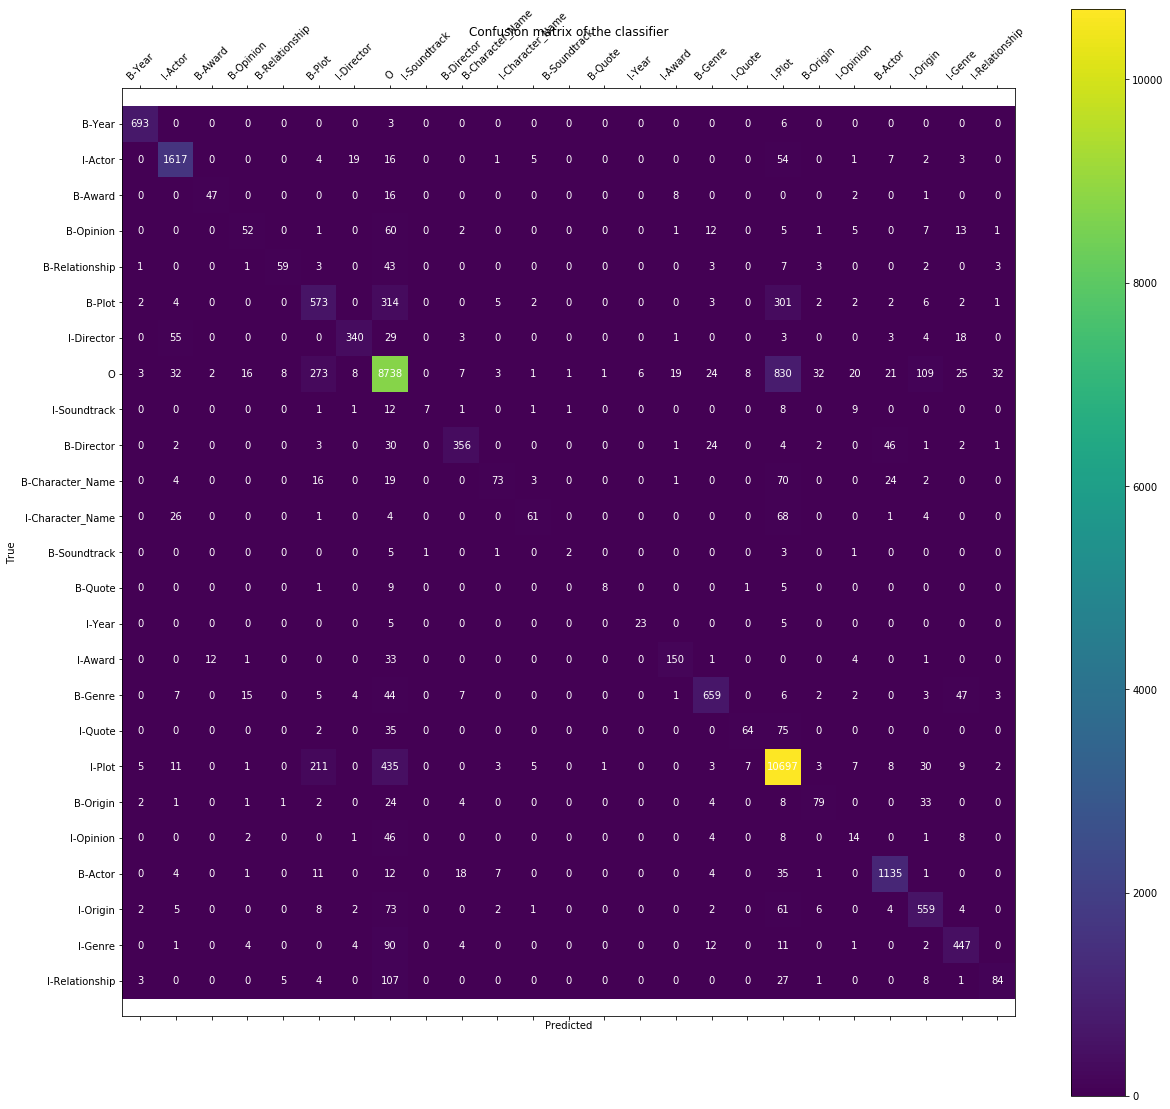

In [42]:
# Inspection of low performing classes and confusion matrix

report1 = classification_report(y_test, preds, output_dict=True)
# Transformation to dataframe to find lowest precisions
df2 = pd.DataFrame(report1).transpose()
print('THE CLASSES WITH THE LOWEST PRECISION: ')
display(df2.nsmallest(5,'precision'))
print('\n')
print('THE CLASSES WITH THE LOWEST RECALL: ')
display(df2.nsmallest(5,'recall'))

confusion_matrix_heatmap(y_test, preds)

In [43]:
# Minimum feature frequency 

# List of hyperparameter choices (minimum frequency needed for a feature)
feature_minfreq = [1,2,3]

# Pre-processing of training and testing datasets
training_data = [preProcess(example) for example in new_train]
testing_data = [preProcess(example) for example in new_test]

# Training and testing on new hyperparameter values
for i in feature_minfreq:
    ct_minfreq = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq": i})
    
    print("training tagger...")
    ct_minfreq.train(training_data, TAGGER_PATH)
    print('done')
    print("testing tagger...")
    preds = []
    y_test = []
    for sent in testing_data:
        sent_preds = [x[1] for x in ct_minfreq.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y_test.extend(sent_true)
    print('CLASSIFICATION REPORT FOR HYPERPARAMETER feature.minfreq = ' + str(i))
    report_POS = classification_report(y_test, preds)
    print(report_POS)
    print(precision_recall_fscore_support(y_test, preds, average='macro'))

training tagger...
done
testing tagger...
CLASSIFICATION REPORT FOR HYPERPARAMETER feature.minfreq = 1
                  precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.92      1229
         B-Award       0.77      0.64      0.70        74
B-Character_Name       0.77      0.34      0.48       212
      B-Director       0.89      0.75      0.81       472
         B-Genre       0.87      0.82      0.84       805
       B-Opinion       0.55      0.33      0.41       160
        B-Origin       0.60      0.50      0.54       159
          B-Plot       0.51      0.47      0.49      1219
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.81      0.47      0.60       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.91      0.94      0.92      1729
         I-Award       0.82      0.74      0.78       202
I-Character_Name       0.7

In [44]:
# Sole Use of c2

# List of hyperparameter choices (c2 co-efficients)
feature_minfreq = [0.25, 0.5, 0.75]

# Pre-processing of training and testing data
training_data = [preProcess(example) for example in new_train]
testing_data = [preProcess(example) for example in new_test]

# Training and testing on new hyperparameter values
for i in feature_minfreq:
    ct_minfreq = CRFTagger(feature_func=get_features, training_opt={"c2": i})
    
    print("training tagger...")
    ct_minfreq.train(training_data, TAGGER_PATH)
    print('done')
    print("testing tagger...")
    preds = []
    y_test = []
    for sent in testing_data:
        sent_preds = [x[1] for x in ct_minfreq.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y_test.extend(sent_true)
    print('CLASSIFICATION REPORT FOR HYPERPARAMETER c2 = ' + str(i))
    report_POS = classification_report(y_test, preds)
    print(report_POS)
    print(precision_recall_fscore_support(y_test, preds, average='macro'))

training tagger...
done
testing tagger...
CLASSIFICATION REPORT FOR HYPERPARAMETER c2 = 0.25
                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1229
         B-Award       0.75      0.65      0.70        74
B-Character_Name       0.70      0.42      0.53       212
      B-Director       0.90      0.77      0.83       472
         B-Genre       0.88      0.83      0.86       805
       B-Opinion       0.58      0.39      0.47       160
        B-Origin       0.59      0.48      0.53       159
          B-Plot       0.50      0.47      0.48      1219
         B-Quote       0.67      0.25      0.36        24
  B-Relationship       0.76      0.52      0.62       125
    B-Soundtrack       0.40      0.15      0.22        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.81      0.79      0.80       202
I-Character_Name       0.74      0.4

In [45]:
# Use of c1 and c2 (Elastic smth)


# Sets of c1 and c2 to test
c1s = [0.25, 0.5, 0.75]
c2s = [0.75, 0.5, 0.25]

# Pre-processing of training and testing data
training_data = [preProcess(example) for example in new_train]
testing_data = [preProcess(example) for example in new_test]

# Training and testing on new hyperparameter values
for i in range(len(c1s)):
    ct_tester = CRFTagger(feature_func=get_features, training_opt={"c1": c1s[i],
                                                                   "c2":c2s[i]})  # initialize tagger with get_features function
    
    print("training tagger...")
    ct_tester.train(training_data, TAGGER_PATH)
    print("done")
    
    print("testing tagger...")
    preds = []
    y_test = []
    testing_data = [preProcess(example) for example in new_test]
    for sent in testing_data:
        sent_preds = [x[1] for x in ct_tester.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y_test.extend(sent_true)
    print("done")
    
    report_POS = classification_report(y_test, preds)
    print('Classification Report for hyperparameters: c1 = ' + str(c1s[i]) + ' and c2 = ' + str(c2s[i]))
    print(report_POS)
    print(precision_recall_fscore_support(y_test, preds, average='macro'))

training tagger...
done
testing tagger...
done
Classification Report for hyperparameters: c1 = 0.25 and c2 = 0.75
                  precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.92      1229
         B-Award       0.75      0.62      0.68        74
B-Character_Name       0.77      0.35      0.48       212
      B-Director       0.89      0.76      0.82       472
         B-Genre       0.88      0.82      0.85       805
       B-Opinion       0.56      0.34      0.43       160
        B-Origin       0.59      0.50      0.54       159
          B-Plot       0.51      0.47      0.49      1219
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.81      0.48      0.60       125
    B-Soundtrack       0.75      0.23      0.35        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.91      0.94      0.93      1729
         I-Award       0.79      0.75      0.77       202
I-Character_Nam

In [46]:
# Final results on original test data, using all training data, with best settings from dev set:

# Optimal preProcess()
def preProcess(example):
    pos = posttagger.tag([s[0] for s in example])
    prev_word = []
    for i in range(len(example)):
        if i == 0:
            prev_word.append('<S>')
        else:
            prev_word.append(example[i - 1][0])
    preprocessed_example = [list(('@'.join([s[0], pos[1]]), s[1])) for s,pos in zip(example, pos)]
    for i in range(len(preprocessed_example)):
        preprocessed_example[i][0] = preprocessed_example[i][0] + '~' + prev_word[i]
    for i in range(len(preprocessed_example)):
        if i == 0:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + '<S>'
        else:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '±' + str(pos[i - 1][1])
    for i in range(len(preprocessed_example)):
        if i == len(preprocessed_example) -1:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '§' + '<E>'
        else:
            preprocessed_example[i][0] = preprocessed_example[i][0] + '§' + str(pos[i + 1][1])
    preprocessed_example = [tuple(l) for l in preprocessed_example]
    return preprocessed_example

# Optimal get_features()
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    POS_tag = token.split('@')[1].split('~')[0]
    prev_window = token.split('@')[1].split('~')[1].split('±')[0]
    prev_pos = token.split('@')[1].split('~')[1].split('±')[1].split('§')[0]
    next_pos = token.split('@')[1].split('~')[1].split('±')[1].split('§')[1]
    token = token.split('@')[0]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[2])    
        
    # Previous Window
    feature_list.append('prevwind_' + prev_window)

    # Previous pos
    feature_list.append('prevpos_' + prev_pos)

    # Next pos
    feature_list.append('nextpos_' + next_pos)
    
    # POS tag
    feature_list.append('POS_' + POS_tag)


    feature_list.append("WORD_" + token)

    return feature_list

# Testing the get_features function
print(get_features(('Michael@Name~When±PRO§DT', 'B-Actor'),0))

# Prepare the train data:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")
train_data = [preProcess(example) for example in raw_training_data]
print(len(train_data), "instances")
print(sum([len(sent) for sent in train_data]), 'words')


# Prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print('TRAINING DATA:')
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
# Initialising of tagger with optimal hyperparameters
ct_final = CRFTagger(feature_func=get_features, training_opt={"c2": 0.25,"c1":0.75})  # initialize tagger with get_features function
print("training tagger...")
ct_final.train(train_data, TAGGER_PATH)
print("done")

# Load tagger from saved file
ct_final.set_model_file(TAGGER_PATH)  # load model from file
print('TESTING DATA:')
print(len(raw_test_data), "instances")
print(sum([len(sent) for sent in raw_test_data]), "words")

# Test the CRF BIO-tag tagger on all training data
print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct_final.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

# Classification report
report_POS = classification_report(y_test, preds)
print(report_POS)
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['CAPITALIZATION', 'SUF_l', 'SUF_el', 'SUF_ael', 'PRE_M', 'PRE_i', 'PRE_c', 'prevwind_When', 'prevpos_PRO', 'nextpos_DT', 'POS_Name', 'WORD_Michael']
7816 instances
158823 words
TRAINING DATA:
1953 instances
39035 words
training tagger...
done
TESTING DATA:
1953 instances
39035 words
testing tagger on test data...
done
                  precision    recall  f1-score   support

         B-Actor       0.90      0.91      0.91      1274
         B-Award       0.69      0.68      0.69        66
B-Character_Name       0.72      0.43      0.54       283
      B-Director       0.82      0.83      0.83       425
         B-Genre       0.84      0.78      0.81       789
       B-Opinion       0.46      0.37      0.41       195
        B-Origin       0.51      0.40      0.45       190
          B-Plot       0.52      0.50      0.51      1577
         B-Quote       0.79      0.40      0.54        47
  B-Relationship       0.78      0.55      0.64       171
    B-Soundtrack       1.00      0.12   